Nil Agell u172941

Jordi Badia u173484

Cristian Bassotto u210426

# PART 1 - Text Processing

## Importing libraries

In [131]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [132]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [133]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
import math
import numpy as np
import collections
from numpy import linalg as la
import re
import json

## Opening and loading files

We open the json document and read line by line. Once the lines have been read, we load the json and we can verify that there are a total of 4000 tweets:

In [161]:
#data_path = '/Users/nilagellllusa/Library/CloudStorage/OneDrive-Personal/Nil/UNI/4/trim1/IRWA/IRWA - Project-20221018/data/'
data_path = './../data/'
docs_path = data_path + 'tw_hurricane_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()

print('Number of tweets:', len(lines))
lines = [json.loads(l) for l in lines]

Number of tweets: 4000


We also open the csv document, which will allow us to map the tweets id with the document ids.

In [135]:
import pandas as pd
# define the dataset location
#filename = '/Users/nilagellllusa/Library/CloudStorage/OneDrive-Personal/Nil/UNI/4/trim1/IRWA/IRWA - Project-20221018/data/tweet_document_ids_map.csv'
filename = data_path + 'tweet_document_ids_map.csv'
sep="\t"
# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)
# Read the data as a dataframe
data = pd.read_csv(filename,sep,names=["doc", "id"])
data.head()

C:\Users\Utente\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,doc,id
0,doc_1,1575918182698979328
1,doc_2,1575918151862304768
2,doc_3,1575918140839673873
3,doc_4,1575918135009738752
4,doc_5,1575918119251419136


## Preprocessing

In [136]:
def build_terms(line):
    """
    Preprocess the tweet text removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line=  line.lower() ## Transform in lowercase
    line=  line.split() ## Tokenize the text to get a list of terms
    tweet_text=[]
    for word in line:
        #let's try to maintain the links in the correct format for the last part
        if "https" not in word: #we maintain the # and @ because have relevance and we delete all the punctuation
            word = re.sub(r'[^\w\s#@]','', word)
            word = re.sub(r'_','',word)

        if word:
            tweet_text.append(word) 
            
    line=[word for word in tweet_text if not word in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line=[stemmer.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    ## END CODE
    return line

# Part 2: Indexing and Evaluation

## 2.1 Indexing

### 2.1.1 Build inverted index

We create the index tfidf (also provided with the class code ):

In [137]:
def create_index_tfidf(tweets, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the input document
    idf = defaultdict(float)

    for tweet in tweets:
        tw_id = tweet['id']
        terms = build_terms(tweet['full_text'])
        for i in range(len(data)):
            if data['id'][i] == tw_id:
                doc_id = data['doc'][i]

        ## ===============================================================        
        ## create the index for the **current page** and store it in current_page_index
        ## current_doc_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}


        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_doc_index = {}

        for position, term in enumerate(terms):  ## terms contains tweet text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_doc_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_doc_index[term] = [doc_id, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_doc_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_doc_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1]) / norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current doc index with the main index
        for term_doc, posting_doc in current_doc_index.items():
            index[term_doc].append(posting_doc)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents / df[term])), 4)

    return index, tf, df, idf

We generate the new indexing:

In [138]:
import time
start_time = time.time()
num_documents = len(lines)
index, tf, df, idf = create_index_tfidf(lines, num_documents)
print("Total time to create the TD-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the TD-IDF index: 396.86 seconds


### 2.1.2 Ranking

We rank the documents with the provided function in class:

In [139]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies

    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # TODO: check how to vectorize the query
        # query_vector[termIndex]=idf[term]  # original
        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        result_docs, doc_scores = search(query, index, idf, tf, 'tf_idf')
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [140]:
def rankTweetsPersonalized(terms, docs, index, idf, tf):
    
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    tweets_ids -- list of tweet ids, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    resultScores --  List of ranked scores of tweets
    resultTweets --  List of ranked tweet ids
    """
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # TODO: check how to vectorize the query
        # query_vector[termIndex]=idf[term]  # original
        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    
    
    
    #Once we have the scoring of TF-IDF apply variations to the ranking
    
    #Get all the tweet data from the tweet_ids 
    query_tweets = {}
    likes_count = []
    likesByFollow = []
    retweets_count = []
    retweetsByFollow = []


    for k in docs:
        for i in range(len(data)):
            if data['doc'][i] == k:
                tw_id = data['id'][i]


        for j in range(len(lines)):
            if lines[j]['id'] == tw_id:
                tweet = lines[j]
                query_tweets[tweet["id"]]=tweet
                likes_count.append(tweet["favorite_count"])
                retweets_count.append(tweet["retweet_count"])
                if tweet["user"]["followers_count"]==0:
                    likesByFollow.append(0)
                    retweetsByFollow.append(0)
                else:
                    
                    likesByFollow.append(tweet["favorite_count"]/tweet["user"]["followers_count"])

                    retweetsByFollow.append(tweet["retweet_count"]/tweet["user"]["followers_count"]) 

    #Normalize the likes and retweets among all the query output tweets
    likesnorm = la.norm(likes_count)
    retnorm = la.norm(retweets_count)
    likes_norma = [float(r/likesnorm) for r in likes_count]
    retweets_norma = [float(r/retnorm) for r in retweets_count]
    
    #Take care of the hsahtags freq
    hashfreq = hashtagsFreq(query_tweets)
    
    #Calculate the ponderation of the hashtags, we want to undervaluate tweets that add to much hashtags for spam
    #To do so we calculate 1/num of hashtags to add to the score
    #Also if it has a trend hashtag need to increase its score
   
    #Select every stat weight in the popularity score

    likes = 0.40
    rets = 0.40
    l_f = 0.10
    r_f = 0.010
    
    pop_scores = {}
    listids = list(docs)
    for x in range(len(listids)):
        pop_scores[listids[x]] = likes*likes_norma[x]+ rets*retweets_norma[x] + l_f*likesByFollow[x] + r_f*retweetsByFollow[x]
    
                                     
    #select the value of tfid and popularity scores in the final score
    tfidfs = 0.3
    pops = 0.7
    
    tfidfnorm = la.norm([r[0] for r in doc_scores])
    popsnorm = la.norm(list(pop_scores.values()))
    #normalize to reduce the difference in scoring in both methods
   
    tweetScores = [ [np.dot(curTweetVec, query_vector)/tfidfnorm*tfidfs + pops*pop_scores[tweet_id]/popsnorm, tweet_id] for tweet_id, curTweetVec in doc_vectors.items() ]
    
    tweetScores.sort(reverse=True)

    resultTweets = [x[1] for x in tweetScores]
    resultScores = [x[0] for x in tweetScores]

    if len(resultTweets) == 0:
        print("No results found, try again")
        
    #return rank punctuation and ids

    return resultTweets, resultScores

In [157]:
def Word2Vec_function(terms, docs):
    """
    Perform Word2Vec to rank the results of a search query based on the emeding of the words
    
    Argument:
    terms -- list of query terms
    tweets_ids -- list of the tweets ids
    
    Returns:
    The list of ranked tweets and 
    the list of their scores 
    """
    text_means={}
    for k in docs:
        for i in range(len(data)):
            if data['doc'][i] == k:
                tw_id = data['id'][i]
        for j in range(len(lines)):
            if lines[j]['id'] == tw_id:
                tweet = lines[j]
        text_pre= build_terms(tweet['full_text'])
        text_pre = " ".join(text_pre)
        model = Word2Vec(text_pre, workers=4, vector_size=100, min_count=1, window=5)
        X = model.wv[model.wv.index_to_key]
        text_means[k]=np.mean(np.asarray(X), axis=0)
    query = " ".join(terms)
    model = Word2Vec(query, workers=4, vector_size=100, min_count=1, window=5)
    X = model.wv[model.wv.index_to_key]
    query_mean=np.mean(np.asarray(X), axis=0)
    tweet_scores=[[np.dot(curDocVec, query_mean), doc] for doc, curDocVec in text_means.items() ]
    tweet_scores.sort(reverse=True)
    result_tweets = [x[1] for x in tweet_scores]
    
    tweet_scores_dict = {item[1]: item[0] for item in tweet_scores}
    result_tweets_2 = []
    tweet_scores_2 = []
    for result_id in result_tweets:
        all_words=True
        for term in terms:
            for i in range(len(data)):
                if data['doc'][i] == k:
                    tw_id = data['id'][i]
            for j in range(len(lines)):
                if lines[j]['id'] == tw_id:
                    tweet = lines[j]
            if term not in build_terms(tweet['full_text']):                
                all_words=False
        if all_words==True:
            result_tweets_2.append(result_id)
            tweet_scores_2.append([tweet_scores_dict[result_id], result_id])

    if len(result_tweets_2) == 0:
        print("No results found, try again")
        
    return result_tweets_2, tweet_scores_2

In [142]:
def hashtagsFreq(tweets):
    hashtags = []
    for t in tweets.values():
        for hashtag in t["entities"]["hashtags"]:
            hashtags.append("#"+hashtag["text"])
    hashcount = collections.Counter(hashtags)
    hashnorm = la.norm(list(hashcount.values()))
    for h, c in hashcount.items():
        hashcount[h] = c/hashnorm
    return hashcount

In [143]:
def bm25_score(terms, docs, index, idf, tf, k1 = 1.4 , b = 0.75):
    """
    Perform the ranking of the results of a search based on bm25 algorithm
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    k1 - parameter of the BM25 formula set to 1.4 by default 
    b - parameter of the BM25 formula set to 0.75 by default 
    
    Returns:
    The list of ranked tweets by BM25 and 
    the list of their scores 
    """
    # dl - dict with the length (counting only index terms) of each doc
    dl = {}
    for doc in docs:
        doc_length = 0
        for item in doc:
            if item in index:
                doc_length += 1
        dl[doc] = doc_length
        
    # adl - float with the average document length of the collection
    adl = np.mean([float(length) for length in dl.values()])
    
    bm25_score = 0
    results = defaultdict(lambda:0) # for each doc we have a dict where the key is each term of the query term and the value its score
    
    for term in terms:  #for each term in the query 
        if term not in index: #if term is not in index go to the next term 
            continue

        for doc_index, (doc, postings) in enumerate(index[term]): #for each document containing that term 
            if doc in docs:
                len_norm = (1-b) + b * (dl[doc] / adl)
                num = (k1 + 1) * tf[term][doc_index]
                denom = tf[term][doc_index] + k1 * len_norm
                results[doc] += (num/denom) * idf[term]  #take the tf in that doc and multiply it by the idf 

    sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse = True)) #sort the results 
    
    ranked_docs = list(sorted_results.keys())
    doc_scores = list(sorted_results.values())
    
    if len(results) == 0: #if we did not find any docs 
        print("No results found, try again")
        
    return ranked_docs, doc_scores

#### Searching

We get the ranked list of docs by getting the id of the docs that contain the query term:

In [144]:
def search(query, index, idf, tf, function = 'tf_idf', k1 = 1.4, b = 0.75):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    
    if function == 'tf_idf':
        ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf)
    elif function == 'tf_idf personalized':
        ranked_docs, doc_scores = rankTweetsPersonalized(query, docs, index, idf, tf)
    elif function == 'bm25':
        ranked_docs, doc_scores = bm25_score (query, docs, index, idf, tf, k1, b)
    elif function == 'word2vec':
        ranked_docs, doc_scores = Word2Vec_function(query, docs)
    else:
        raise Exception('Error: no function of type ' + function)
            
    return ranked_docs, doc_scores

We create an auxiliary function to list the hashtags of a tweet:

In [145]:
def list_hashtags(tweet):
    hashtags = []
    for tag in tweet["entities"]["hashtags"]: #we loop the hashtags of the tweet that we can find in tweet["entities"]["hashtags"]
        hashtags.append("#"+tag["text"])
    return ' '.join(hashtags).strip()

#### Tweet display

We create a function to display the relevant information of the tweet ( we also added the document to see it works properly):

In [146]:
def tweet_display(tweets, idd,data):
    for i in range(len(data)):
        if data['doc'][i] == idd: #we map the doc_id to the tweet_id
            doc = data['doc'][i]
            tw_id = data['id'][i]
            for tweet in tweets: #we loop all tweets until we find the one with the corresponding tweet_id, then we display
                if (tweet['id']) == tw_id:
                    return"Document : "+ str(doc)+  " | " +" Tweet: " + str(tweet['full_text']) + " | " + "Username: " + str(tweet["user"]["name"]) + " | " + "Date: "+ str(tweet["created_at"]) + " | " + "Hashtags: " + list_hashtags(tweet) + " | " + "Likes: " +  str(tweet["favorite_count"]) + " | " + "Retweets: "+ str(tweet["retweet_count"]) + " | " + "Url: " + "twitter.com/"+str(tweet["user"]["id"])+"/status/"+tweet['id_str']+"\n"


Here we have an example of a possible query and its results:

In [147]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs, doc_scores = search(query, index, idf, tf, 'tf_idf personalized')
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(tweet_display(lines, d_id,data))

Insert your query (i.e.: Computer Science):

computer

Top 10 results out of 3 for the searched query:

Document : doc_3331 |  Tweet: #JunkScience "study" sez "man-caused" #GlobalWarming added 10% rain to #HurricaneIan?
•Computer simulation? Same scam that saw 2.2Μ #Covid dead in US?
•Gov't lab
•Not peer-reviewed
•Pimped by #FakeNews @AP 
•You'd buy eco-dictatorship "to save earth"?
https://t.co/ztid0sqLhK | Username: The Fraser Faithful | Date: Fri Sep 30 15:08:32 +0000 2022 | Hashtags: #JunkScience #GlobalWarming #HurricaneIan #Covid #FakeNews | Likes: 2 | Retweets: 2 | Url: twitter.com/875111535517028357/status/1575865182944894978

Document : doc_1798 |  Tweet: Stuck in WA state due to #hurricaneian - Damage assessment has commenced through the use of @CrisisTrack on my 12-yr old’s school computer. 😂 a week trip turned into a two week trip. #paradisefloodie https://t.co/KiCwlOYIRy | Username: CFM Flood Mgr | Date: Fri Sep 30 16:45:21 +0000 2022 | Hashtags: #hurricaneian #paradiseflo

In [148]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs, doc_scores = search(query, index, idf, tf, 'word2vec')
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(tweet_display(lines, d_id,data))

Insert your query (i.e.: Computer Science):

computer

Top 20 results out of 3 for the searched query:

Document : doc_3900 |  Tweet: HURRICANE IAN RECOVERY: Christian Tech Center Ministries is pleased to announce the launch of our #HurricaneIan tech recovery program to assist local households affected by this storm. If your computer has been damaged or is no longer working as a result of Ian's impact, https://t.co/WIofQW4nzc | Username: Christian Tech Center Ministries | Date: Fri Sep 30 14:38:22 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/1333552175004475397/status/1575857591602712576

Document : doc_1798 |  Tweet: Stuck in WA state due to #hurricaneian - Damage assessment has commenced through the use of @CrisisTrack on my 12-yr old’s school computer. 😂 a week trip turned into a two week trip. #paradisefloodie https://t.co/KiCwlOYIRy | Username: CFM Flood Mgr | Date: Fri Sep 30 16:45:21 +0000 2022 | Hashtags: #hurricaneian #paradisefloodie | Like

In [149]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs, doc_scores = search(query, index, idf, tf, 'bm25')
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(tweet_display(lines, d_id,data))

Insert your query (i.e.: Computer Science):

computer

Top 10 results out of 3 for the searched query:

Document : doc_1798 |  Tweet: Stuck in WA state due to #hurricaneian - Damage assessment has commenced through the use of @CrisisTrack on my 12-yr old’s school computer. 😂 a week trip turned into a two week trip. #paradisefloodie https://t.co/KiCwlOYIRy | Username: CFM Flood Mgr | Date: Fri Sep 30 16:45:21 +0000 2022 | Hashtags: #hurricaneian #paradisefloodie | Likes: 1 | Retweets: 0 | Url: twitter.com/849291804390309889/status/1575889546101035008

Document : doc_3331 |  Tweet: #JunkScience "study" sez "man-caused" #GlobalWarming added 10% rain to #HurricaneIan?
•Computer simulation? Same scam that saw 2.2Μ #Covid dead in US?
•Gov't lab
•Not peer-reviewed
•Pimped by #FakeNews @AP 
•You'd buy eco-dictatorship "to save earth"?
https://t.co/ztid0sqLhK | Username: The Fraser Faithful | Date: Fri Sep 30 15:08:32 +0000 2022 | Hashtags: #JunkScience #GlobalWarming #HurricaneIan #Covid #Fake

### 2.1.3 Test queries 

The dataset concern a hurrican, so we have decided for the test query 5 words that are related to this phenonim like flood, hurrican, landfall, emergency (because is a natural disaster) and Florida (for the last big hurrican Ian).

These are the most frequent terms in the tweets

#### Test 1: Flood

In [151]:
#1
query = 'flood'

top = 20
methods = ['tf_idf', 'tf_idf personalized', 'word2vec', 'bm25']
for method in methods:
    ranked_docs, doc_scores = search(query, index, idf, tf, method)
    print("\n\n======================\n\nTop {} results out of {} ranked using {}:\n".format(top, len(ranked_docs), method))
    for d_id in ranked_docs[:top]:
        print(tweet_display(lines, d_id, data))




Top 20 results out of 261 ranked using tf_idf:

Document : doc_1493 |  Tweet: It’s not the wind that’s so bad for us in the lowcountry ; like in Florida it’s the wind I worry about. Here it’s the FLOODING. The lowcountry floods during regular rain storms; hurricanes can flood out so many homes so fast here. #HurricaneIan | Username: qaatil🐺 | #BlackRiddler 🎲 | Date: Fri Sep 30 17:14:34 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/958535964/status/1575896898481053697

Document : doc_2488 |  Tweet: If you are in a flood zone, you will be required by your mortgage company to carry a flood policy.  Here is what it covers. 
#HurricaneIan #floodinsurance https://t.co/FEiq7SI4cq | Username: Tony Tyan | Date: Fri Sep 30 15:51:01 +0000 2022 | Hashtags: #HurricaneIan #floodinsurance | Likes: 0 | Retweets: 0 | Url: twitter.com/1551356616/status/1575875872934232064

Document : doc_1862 |  Tweet: This is near where I live. Flood didn't affect me. Caused by flo

Document : doc_3184 |  Tweet: #HurricaneIan Flooded Angelo Dawkins' Home 

https://t.co/FYXabtuMZy | Username: PWStream | Date: Fri Sep 30 15:16:19 +0000 2022 | Hashtags: #HurricaneIan | Likes: 7 | Retweets: 8 | Url: twitter.com/2942334940/status/1575867141169025024

Document : doc_1562 |  Tweet: #HurricaneIan, with intense storm surges and rapid flooding, has devasted communities across #Florida. #BlackSky captured imagery showing just a portion of the extensive damage in #FortMyers Beach. Our hearts are with all those affected by this tragedy. https://t.co/v9fk4tbbTa | Username: BlackSky | Date: Fri Sep 30 17:07:07 +0000 2022 | Hashtags: #HurricaneIan #Florida #BlackSky #FortMyers | Likes: 20 | Retweets: 8 | Url: twitter.com/3247103250/status/1575895024247750656

Document : doc_2564 |  Tweet: FIRST ALERT: High tide adding to the storm surge ongoing now along the Grand Strand. Lots of flooding around Myrtle Beach! #HurricaneIan soon to make landfall just south of there. #ian #CLT @WBT

Document : doc_3465 |  Tweet: Lots of flash flooding today… I’m at a sturdy hotel high off the ground thankfully. The power went out this morning, so the generator kicked in. Worried about where I live for sure since it’s right near the water… but hoping for the best. Stay safe everyone ❤️ #HurricaneIan | Username: Callie | Date: Fri Sep 30 15:02:19 +0000 2022 | Hashtags: #HurricaneIan | Likes: 2 | Retweets: 0 | Url: twitter.com/2370920383/status/1575863618356547584

Document : doc_3288 |  Tweet: We're still without power &amp; no estimate for restoration so we went to a hotel. There is minor damage to our roof &amp; some flood damage but nothing major. Everything in our fridge &amp; freezer is gone. But it could've been much worse!! #HurricaneIan | Username: Shelley Benhoff 👑 | Date: Fri Sep 30 15:10:27 +0000 2022 | Hashtags: #HurricaneIan | Likes: 17 | Retweets: 0 | Url: twitter.com/900253176/status/1575865666522914816




Top 20 results out of 261 ranked using bm25:

Document : doc_

#### Test 2 : Emergency

In [152]:
#2
query = 'emergency'
top = 20
for method in methods:
    ranked_docs, doc_scores = search(query, index, idf, tf, method)
    print("\n\n======================\n\nTop {} results out of {} ranked using {}:\n".format(top, len(ranked_docs), method))
    for d_id in ranked_docs[:top]:
        print(tweet_display(lines, d_id,data))




Top 20 results out of 95 ranked using tf_idf:

Document : doc_2682 |  Tweet: Our thoughts and prayers are with the people of Florida. Members, please continue to check your email for important updates from the VTA about emergency waivers and @GovernorVA 's state of emergency declaration as we prepare for #HurricaneIan.
https://t.co/BXXJMxed3J | Username: Va Trucking Assn. | Date: Fri Sep 30 15:40:56 +0000 2022 | Hashtags: #HurricaneIan | Likes: 1 | Retweets: 1 | Url: twitter.com/80934149/status/1575873336596647937

Document : doc_588 |  Tweet: Disaster-Preparedness Training Expert and author, Haskell Moore, says, “save your phone for emergency communications and have two trusty flashlights minimum is my advice in any emergency,” Read more on the blog. https://t.co/Ajy4q4KZ5O
#maglite
#flashlite
#hurricaneian | Username: MAGLITE | Date: Fri Sep 30 18:10:01 +0000 2022 | Hashtags: #maglite #flashlite #hurricaneian | Likes: 2 | Retweets: 1 | Url: twitter.com/2774222486/status/1575910855




Top 20 results out of 95 ranked using tf_idf personalized:

Document : doc_2221 |  Tweet: Search and rescue teams are working 24/7 to help those in need in the aftermath of #HurricaneIan.

To aid in Florida’s efforts, please visit https://t.co/QSlfv3Jg5N to help emergency personnel locate you or your loved ones. | Username: Joseph A. Ladapo, MD, PhD | Date: Fri Sep 30 16:07:43 +0000 2022 | Hashtags: #HurricaneIan | Likes: 173 | Retweets: 54 | Url: twitter.com/1445440065409363972/status/1575880079267225600

Document : doc_1954 |  Tweet: "VERY SOBERING SCENE":  Emergency responders line highway as Florida recovers from #HurricaneIan  https://t.co/I5kqrLj2Bs https://t.co/8haJVRvyGG | Username: WFLA NEWS | Date: Fri Sep 30 16:30:33 +0000 2022 | Hashtags: #HurricaneIan | Likes: 66 | Retweets: 14 | Url: twitter.com/23820899/status/1575885824851312640

Document : doc_1852 |  Tweet: #HurricaneIan left at least 21 people dead in #Florida, according to the state's Division of Emergency Manage




Top 20 results out of 95 ranked using word2vec:

Document : doc_2125 |  Tweet: .@POTUS has spoken with SC Governor @HenryMcMaster about aid with #HurricaneIan. The President issued an Emergency Declaration for the state last night. | Username: Janae Bowens | Date: Fri Sep 30 16:15:28 +0000 2022 | Hashtags: #HurricaneIan | Likes: 2 | Retweets: 1 | Url: twitter.com/365825064/status/1575882028725067776

Document : doc_1559 |  Tweet: Charleston County emergency services were suspended Friday as officials prepared for Hurricane Ian to make landfall on South Carolina's coast.

#HurricaneIan #hurricane #SouthCarolina #Charleston | Username: CGTN America | Date: Fri Sep 30 17:07:38 +0000 2022 | Hashtags: #HurricaneIan #hurricane #SouthCarolina #Charleston | Likes: 1 | Retweets: 0 | Url: twitter.com/620136960/status/1575895155181322240

Document : doc_445 |  Tweet: The Internal Revenue Service is deploying 400 employees to assist with the federal emergency response to Hurricane Ian, includin

#### Test 3 : Hurricane

In [153]:
#3
query = 'hurricane'
top = 20
for method in methods:
    ranked_docs, doc_scores = search(query, index, idf, tf, method)
    print("\n\n======================\n\nTop {} results out of {} ranked using {}:\n".format(top, len(ranked_docs), method))
    for d_id in ranked_docs[:top]:
        print(tweet_display(lines, d_id,data))




Top 20 results out of 631 ranked using tf_idf:

Document : doc_3218 |  Tweet: If the death doll isn't more than hurricane katrina, its pretty damn close. #HurricaneIan was absolutely worse than hurricane charley for Florida..and was THE STRONGEST hurricane in recorded history for our florida peninsula. | Username: Emily Bailee | Date: Fri Sep 30 15:14:25 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/45058299/status/1575866662070484994

Document : doc_640 |  Tweet: Hurricane Ian before and after #HurricaneIan https://t.co/XZstkI2pN2 | Username: kaden fields ✪ | Date: Fri Sep 30 18:07:50 +0000 2022 | Hashtags: #HurricaneIan | Likes: 2 | Retweets: 0 | Url: twitter.com/1329640781649416197/status/1575910304159977472

Document : doc_3845 |  Tweet: So please y'all, hold off on the severe hurricane jokes because this hurricane isn't a joke right now. And it never will be. #hurricaneian | Username: UNDERCUT SEONGHWA ENTHUSIAST ‼️🤩 | Date: Fri Sep 30 14:41:0




Top 20 results out of 631 ranked using word2vec:

Document : doc_2140 |  Tweet: #hurricaneian
The perpetual hurricane Ian | Username: 💥PermanentWave | Date: Fri Sep 30 16:14:34 +0000 2022 | Hashtags: #hurricaneian | Likes: 0 | Retweets: 0 | Url: twitter.com/75442215/status/1575881799267295234

Document : doc_1217 |  Tweet: Hurricane Ian on tour😭
#HurricaneIan | Username: New York City | Date: Fri Sep 30 17:37:34 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/1068652828661559297/status/1575902689040666626

Document : doc_2537 |  Tweet: PRAY 🙏 FOR ALL WHO SUFFERED FROM THE HURRICANE #HurricaneIan | Username: Gamingforlife | Date: Fri Sep 30 15:48:48 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/1565775847960739841/status/1575875317918748679

Document : doc_286 |  Tweet: How come all of the hurricanes that start with the letter ‘I’ cause the most chaos? #HurricaneIan | Username: CremedelaCreme | Date: Fri Sep 30 18:24

#### Test 4 : Florida

In [154]:
#4
query = 'florida'
top = 20
for method in methods:
    ranked_docs, doc_scores = search(query, index, idf, tf, method)
    print("\n\n======================\n\nTop {} results out of {} ranked using {}:\n".format(top, len(ranked_docs), method))
    for d_id in ranked_docs[:top]:
        print(tweet_display(lines, d_id,data))




Top 20 results out of 547 ranked using tf_idf:

Document : doc_2072 |  Tweet: Donate to the Florida Disaster Fund - Volunteer Florida to help Floridians recover from #hurricaneian  https://t.co/Ud4BNM81EJ | Username: 🇺🇸 Amy☢️REDACTED☢️ MAGArino 🤌🏻🇺🇸 | Date: Fri Sep 30 16:19:57 +0000 2022 | Hashtags: #hurricaneian | Likes: 1 | Retweets: 0 | Url: twitter.com/2398138445/status/1575883154153414656

Document : doc_1700 |  Tweet: The current death toll in Florida sits at 21. About 10,000 people in southwest Florida are unaccounted for. 💔 #hurricaneian | Username: School’s Out | Date: Fri Sep 30 16:55:15 +0000 2022 | Hashtags: #hurricaneian | Likes: 0 | Retweets: 0 | Url: twitter.com/1420132505546465280/status/1575892040541298690

Document : doc_1701 |  Tweet: Update: #hurricaneian has passed Florida and is now headed to South Carolina.

1.8 million remain without power in Florida. | Username: TheLatestBlock.com | Date: Fri Sep 30 16:55:12 +0000 2022 | Hashtags: #hurricaneian | Likes: 0 | 

Document : doc_3964 |  Tweet: Duke Energy donates $100,000 to the Florida Disaster Fund, managed by Volunteer Florida Foundation, to assist communities affected by #HurricaneIan. To contribute to the Florida Disaster Fund, visit https://t.co/zx6l40CRQv or text DISASTER to 20222. Info: https://t.co/oAmCDqYkVQ https://t.co/UVsnxWHWGu | Username: Duke Energy | Date: Fri Sep 30 14:34:42 +0000 2022 | Hashtags: #HurricaneIan | Likes: 13 | Retweets: 11 | Url: twitter.com/81192849/status/1575856667304071170

Document : doc_2304 |  Tweet: #HurricaneIan has devastated Florida and our thoughts continue to be with all those affected. 

We transported at-risk shelter animals out of harm's way as the storm rapidly approached and remain on standby to help in any way we can. Stay tuned for updates as we know more. 💙 https://t.co/kbP1UsFQqi | Username: The Humane Society of the United States | Date: Fri Sep 30 16:01:33 +0000 2022 | Hashtags: #HurricaneIan | Likes: 43 | Retweets: 13 | Url: twitter.com/1

Document : doc_2291 |  Tweet: Praying for my family and friends in Florida #hurricaneian | Username: Royalty by smendy | Date: Fri Sep 30 16:02:16 +0000 2022 | Hashtags: #hurricaneian | Likes: 0 | Retweets: 0 | Url: twitter.com/1561457646552731648/status/1575878706622771202

Document : doc_2899 |  Tweet: They are rebuilding Florida. 
Why? 
#ClimateEmergency #HurricaneIan https://t.co/XNaKn7m7lg | Username: 😷Miriam O'Callaghan Has a Deadline | Date: Fri Sep 30 15:29:48 +0000 2022 | Hashtags: #ClimateEmergency #HurricaneIan | Likes: 4 | Retweets: 3 | Url: twitter.com/1031872658575642624/status/1575870535653011456

Document : doc_2905 |  Tweet: Hurricane Ian heads towards South Carolina after striking Florida.
The death toll in Florida has risen to 21. We are praying for all those affected. Our hearts are with you. #HurricaneIan https://t.co/RqvvtW7Mt5 | Username: lyfmail.com | Date: Fri Sep 30 15:29:30 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/15436

#### Test 5 : Landfall in Carolina

In [159]:
#5
query = 'landfall in Carolina'
top = 20
for method in methods:
    ranked_docs, doc_scores = search(query, index, idf, tf, method)
    print("\n\n======================\n\nTop {} results out of {} ranked using {}:\n".format(top, len(ranked_docs), method))
    for d_id in ranked_docs[:top]:
        print(tweet_display(lines, d_id,data))




Top 20 results out of 437 ranked using tf_idf:

Document : doc_2505 |  Tweet: ⚠️ #HurricaneIan about to make landfall on South Carolina! https://t.co/X61NAwpsx6 | Username: Josh Fitzpatrick | Date: Fri Sep 30 15:50:13 +0000 2022 | Hashtags: #HurricaneIan | Likes: 2 | Retweets: 1 | Url: twitter.com/270440459/status/1575875671385071618

Document : doc_249 |  Tweet: #HurricaneIan makes landfall in South Carolina... https://t.co/vKik1OyOgQ | Username: SFDB | Date: Fri Sep 30 18:26:19 +0000 2022 | Hashtags: #HurricaneIan | Likes: 1 | Retweets: 0 | Url: twitter.com/16832810/status/1575914959091163136

Document : doc_1444 |  Tweet: #HurricaneIan nears landfall in South Carolina - Will impact both Carolinas and Virginia, reports Karen Graham. https://t.co/qttgs1Stbf | Username: Digital Journal | Date: Fri Sep 30 17:20:16 +0000 2022 | Hashtags: #HurricaneIan | Likes: 0 | Retweets: 0 | Url: twitter.com/15135567/status/1575898335281831936

Document : doc_856 |  Tweet: Ian making landfall once 


Document : doc_311 |  Tweet: 🌀 #HurricaneIan has officially made landfall as a Category 1 storm! #scwx #chswx https://t.co/R3al4UAZVf | Username: NWS Charleston, SC | Date: Fri Sep 30 18:23:41 +0000 2022 | Hashtags: #HurricaneIan #scwx #chswx | Likes: 25 | Retweets: 19 | Url: twitter.com/307589282/status/1575914293672824834

Document : doc_2041 |  Tweet: The damage to southwest and central #Florida is overwhelming after #HurricaneIan made landfall as a Category 4 storm earlier this week. In the wake of the devastation, our U.S. Disaster Relief team will be caring for hurting homeowners in Jesus' Name. https://t.co/G2MBTStteR https://t.co/d9cEOZMc7f | Username: Samaritan's Purse | Date: Fri Sep 30 16:22:40 +0000 2022 | Hashtags: #Florida #HurricaneIan | Likes: 35 | Retweets: 16 | Url: twitter.com/20714308/status/1575883838693277696

Document : doc_281 |  Tweet: BREAKING: #HurricaneIan has made 2nd U.S. landfall near Georgetown, SC (between Charleston and Myrtle Beach) as of 2:05p ET. F

## 2.2 Evaluation

### 2.2.1 Test relevance

#### Baseline

In [162]:
search_results = pd.read_csv(data_path + "evaluation_gt.csv")

In [163]:
search_results.rename(columns={'label': 'is_relevant'}, inplace=True)

In [164]:
base_queries = ['Landfall in South Carolina', 'Help and recovery during the hurricane disaster', 'Floodings in South Carolina']

predicted_relevance = []

for pos, row in search_results.iterrows():
    ranked_docs, doc_scores = search(base_queries[row['query_id']-1], index, idf, tf, 'tf_idf')
    if row['doc'] in ranked_docs:
        doc_index = ranked_docs.index(row['doc'])
        predicted_relevance.append(doc_scores[doc_index][0])
    else:
        predicted_relevance.append(0)

search_results['predicted_relevance'] = predicted_relevance
baseline_df = search_results

#### Our evaluation

In [165]:
#create the dataframe with our 5 queries to be evaluated
our_queries = ['flood','emergency','hurricane','florida','landfall']

query_results = pd.DataFrame(columns = ["query_id", "doc_id", "predicted_relevance"])

for i in range(len(our_queries)):
    ranked_docs, doc_scores = search(our_queries[i], index, idf, tf, 'tf_idf')
    for j in range(len(ranked_docs[:10])):
        query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_relevance": doc_scores[j][0]}, ignore_index=True)        


C:\Users\Utente\AppData\Local\Temp\ipykernel_1440\3839198437.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_relevance": doc_scores[j][0]}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_1440\3839198437.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_relevance": doc_scores[j][0]}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_1440\3839198437.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_rel

C:\Users\Utente\AppData\Local\Temp\ipykernel_1440\3839198437.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_relevance": doc_scores[j][0]}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_1440\3839198437.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_relevance": doc_scores[j][0]}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_1440\3839198437.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  query_results = query_results.append({"query_id": i+1, "doc_id": str(ranked_docs[j]), "predicted_rel

In [166]:
# I have assigned each doc to one relevance
doc_score = [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,0,1,1,0,0,1]

In [167]:
query_results["is_relevant"] = doc_score
#query_results["is_relevant"] = query_results["doc_score"].apply(lambda y: 1 if y >= 2 else 0)
#query_results["predicted_bin_relevance"] = query_results["predicted_relevance"].apply(lambda y: 1 if y>=2 else 0)
our_query_df = query_results

#### Inspection of the two dataframe

In [168]:
print('Baseline relevance results: ')
display(baseline_df)

print('Our queries relevance results: ')
display(our_query_df)

Baseline relevance results: 


,doc,query_id,is_relevant,predicted_relevance
0,doc_12,1,1,2.267331
1,doc_9,1,1,1.453629
2,doc_18,1,1,2.294735
3,doc_45,1,1,1.149296
4,doc_501,1,1,3.437695
5,doc_52,1,1,1.083556
6,doc_82,1,1,3.567589
7,doc_100,1,1,2.400649
8,doc_122,1,1,0.788417
9,doc_165,1,1,2.806229


Our queries relevance results: 


,query_id,doc_id,predicted_relevance,is_relevant
0,1,doc_1493,4.014152,0
1,1,doc_2488,3.982116,1
2,1,doc_1862,3.982116,1
3,1,doc_1691,3.674424,1
4,1,doc_3960,3.579062,1
5,1,doc_857,3.331716,1
6,1,doc_1672,3.331716,0
7,1,doc_3488,3.041159,1
8,1,doc_3471,3.041159,1
9,1,doc_3470,3.041159,1


### 2.2.2 Evaluation algorithms

#### Precision@K

In [169]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k]) #hay que ordenar los predicted igual que los del ground truth. Align binary relevance to the 
    relevant = sum(doc_score==1) #get number of relevant docs
    return float(relevant)/k

Evaluation of baseline queries:

In [170]:
k = 5
for i in range(len(base_queries)):
    current_query = i+1
    current_query_res = baseline_df[baseline_df["query_id"] == current_query]

    print("Query: {}\n ==> Precision@{}: {}".format(base_queries[i],k, precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))
    print("Check on the dataset sorted by score:")

    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query: Landfall in South Carolina
 ==> Precision@5: 1.0
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
6,doc_82,1,1,3.567589
4,doc_501,1,1,3.437695
9,doc_165,1,1,2.806229
7,doc_100,1,1,2.400649
2,doc_18,1,1,2.294735


Query: Help and recovery during the hurricane disaster
 ==> Precision@5: 0.8
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
17,doc_402,2,1,2.949660
12,doc_268,2,1,2.360185
19,doc_504,2,1,1.852534
49,doc_1233,2,0,1.299460
11,doc_175,2,1,1.282269


Query: Floodings in South Carolina
 ==> Precision@5: 1.0
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
24,doc_148,3,1,3.079364
29,doc_65,3,1,2.809531
21,doc_65,3,1,2.809531
22,doc_66,3,1,2.208867
20,doc_30,3,1,2.123482


Evaluation of our queries:

In [171]:
for i in range(len(our_queries)):
    current_query = i+1
    current_query_res = our_query_df[our_query_df["query_id"] == current_query]

    print("Query: {}\n ==> Precision@{}: {}".format(our_queries[i],k, precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))
    print("Check on the dataset sorted by score:")

    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query: flood
 ==> Precision@5: 0.8
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
0,1,doc_1493,4.014152,0
1,1,doc_2488,3.982116,1
2,1,doc_1862,3.982116,1
3,1,doc_1691,3.674424,1
4,1,doc_3960,3.579062,1


Query: emergency
 ==> Precision@5: 0.4
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
10,2,doc_2682,5.833453,1
11,2,doc_588,5.595638,0
12,2,doc_1911,5.107419,0
13,2,doc_582,4.946544,1
14,2,doc_1674,4.946544,1


Query: hurricane
 ==> Precision@5: 0.4
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
20,3,doc_3218,2.00628,0
21,3,doc_640,1.70515,0
22,3,doc_3845,1.70515,1
23,3,doc_3336,1.70515,1
24,3,doc_2537,1.70515,0


Query: florida
 ==> Precision@5: 0.6
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
30,4,doc_2072,2.195784,0
31,4,doc_1700,2.115823,0
32,4,doc_1701,2.044174,1
33,4,doc_3964,1.854561,1
34,4,doc_563,1.816164,0


Query: landfall
 ==> Precision@5: 0.8
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
40,5,doc_399,4.597579,1
41,5,doc_100,4.158046,1
42,5,doc_245,3.981278,1
43,5,doc_12,3.927132,1
44,5,doc_314,3.753549,0


#### Recall@K

In [172]:
 def recall_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    order = np.argsort(y_score)[::-1] 
    all_relevants = sum(doc_score == 1)
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1) 
    return float(relevant) / all_relevants #calculate recall at k, which is the number of relevant documents among all relevant docs

In [173]:
# Check for query 1
for i in range(len(base_queries)):
    current_query = i+1
    current_query_res = baseline_df[baseline_df["query_id"] == current_query]
    
    print("Query : {}\n ==> Recall@{}: {}".format(base_queries[i],k, recall_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))
    print("Check on the dataset sorted by score:")
    
    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query : Landfall in South Carolina
 ==> Recall@5: 0.5
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
6,doc_82,1,1,3.567589
4,doc_501,1,1,3.437695
9,doc_165,1,1,2.806229
7,doc_100,1,1,2.400649
2,doc_18,1,1,2.294735


Query : Help and recovery during the hurricane disaster
 ==> Recall@5: 0.4
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
17,doc_402,2,1,2.949660
12,doc_268,2,1,2.360185
19,doc_504,2,1,1.852534
49,doc_1233,2,0,1.299460
11,doc_175,2,1,1.282269


Query : Floodings in South Carolina
 ==> Recall@5: 0.5
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
24,doc_148,3,1,3.079364
29,doc_65,3,1,2.809531
21,doc_65,3,1,2.809531
22,doc_66,3,1,2.208867
20,doc_30,3,1,2.123482


In [174]:
for i in range(len(our_queries)):
    current_query = i+1
    current_query_res = our_query_df[our_query_df["query_id"] == current_query]
    
    print("Query : {}\n ==> Recall@{}: {}".format(our_queries[i],k, recall_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))
    print("Check on the dataset sorted by score:")
    
    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query : flood
 ==> Recall@5: 0.5
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
0,1,doc_1493,4.014152,0
1,1,doc_2488,3.982116,1
2,1,doc_1862,3.982116,1
3,1,doc_1691,3.674424,1
4,1,doc_3960,3.579062,1


Query : emergency
 ==> Recall@5: 0.2857142857142857
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
10,2,doc_2682,5.833453,1
11,2,doc_588,5.595638,0
12,2,doc_1911,5.107419,0
13,2,doc_582,4.946544,1
14,2,doc_1674,4.946544,1


Query : hurricane
 ==> Recall@5: 0.4
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
20,3,doc_3218,2.00628,0
21,3,doc_640,1.70515,0
22,3,doc_3845,1.70515,1
23,3,doc_3336,1.70515,1
24,3,doc_2537,1.70515,0


Query : florida
 ==> Recall@5: 0.6
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
30,4,doc_2072,2.195784,0
31,4,doc_1700,2.115823,0
32,4,doc_1701,2.044174,1
33,4,doc_3964,1.854561,1
34,4,doc_563,1.816164,0


Query : landfall
 ==> Recall@5: 0.5714285714285714
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
40,5,doc_399,4.597579,1
41,5,doc_100,4.158046,1
42,5,doc_245,3.981278,1
43,5,doc_12,3.927132,1
44,5,doc_314,3.753549,0


#### Average Precision@K

In [175]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    order = np.argsort(y_score)[::-1] #same as for precision
    doc_score = np.take(doc_score, order[:k]) #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

In [176]:
for i in range(len(base_queries)):
    current_query = i+1
    current_query_res = baseline_df[baseline_df["query_id"] == current_query]
    
    print("Query : {}\n ==> Average Precision@{}: {}".format(base_queries[i],k, avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k)))
    print("Check on the dataset sorted by score:")
    
    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query : Landfall in South Carolina
 ==> Average Precision@5: 0.5
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
6,doc_82,1,1,3.567589
4,doc_501,1,1,3.437695
9,doc_165,1,1,2.806229
7,doc_100,1,1,2.400649
2,doc_18,1,1,2.294735


Query : Help and recovery during the hurricane disaster
 ==> Average Precision@5: 0.38
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
17,doc_402,2,1,2.949660
12,doc_268,2,1,2.360185
19,doc_504,2,1,1.852534
49,doc_1233,2,0,1.299460
11,doc_175,2,1,1.282269


Query : Floodings in South Carolina
 ==> Average Precision@5: 0.5
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
24,doc_148,3,1,3.079364
29,doc_65,3,1,2.809531
21,doc_65,3,1,2.809531
22,doc_66,3,1,2.208867
20,doc_30,3,1,2.123482


In [177]:
for i in range(len(our_queries)):
    current_query = i+1
    current_query_res = our_query_df[our_query_df["query_id"] == current_query]
    
    print("Query : {}\n ==> Average Precision@{}: {}".format(our_queries[i],k, avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k)))
    print("Check on the dataset sorted by score:")
    
    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query : flood
 ==> Average Precision@5: 0.33958333333333335
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
0,1,doc_1493,4.014152,0
1,1,doc_2488,3.982116,1
2,1,doc_1862,3.982116,1
3,1,doc_1691,3.674424,1
4,1,doc_3960,3.579062,1


Query : emergency
 ==> Average Precision@5: 0.19999999999999998
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
10,2,doc_2682,5.833453,1
11,2,doc_588,5.595638,0
12,2,doc_1911,5.107419,0
13,2,doc_582,4.946544,1
14,2,doc_1674,4.946544,1


Query : hurricane
 ==> Average Precision@5: 0.18
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
20,3,doc_3218,2.00628,0
21,3,doc_640,1.70515,0
22,3,doc_3845,1.70515,1
23,3,doc_3336,1.70515,1
24,3,doc_2537,1.70515,0


Query : florida
 ==> Average Precision@5: 0.2866666666666666
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
30,4,doc_2072,2.195784,0
31,4,doc_1700,2.115823,0
32,4,doc_1701,2.044174,1
33,4,doc_3964,1.854561,1
34,4,doc_563,1.816164,0


Query : landfall
 ==> Average Precision@5: 0.5714285714285714
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
40,5,doc_399,4.597579,1
41,5,doc_100,4.158046,1
42,5,doc_245,3.981278,1
43,5,doc_12,3.927132,1
44,5,doc_314,3.753549,0


#### F1-Score

In [178]:
def f1_score(precision,recall):
    return 2*(precision*recall)/(precision+recall)

In [179]:
for i in range(len(base_queries)):
    current_query = i+1
    current_query_res = baseline_df[baseline_df["query_id"] == current_query]
    
    precision = precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
    recall = recall_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
    print("Query : {}\n ==> F1-SCORE@{}: {}".format(base_queries[i],k,f1_score(precision,recall) ))
    print("Check on the dataset sorted by score:")
    
    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query : Landfall in South Carolina
 ==> F1-SCORE@5: 0.6666666666666666
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
6,doc_82,1,1,3.567589
4,doc_501,1,1,3.437695
9,doc_165,1,1,2.806229
7,doc_100,1,1,2.400649
2,doc_18,1,1,2.294735


Query : Help and recovery during the hurricane disaster
 ==> F1-SCORE@5: 0.5333333333333333
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
17,doc_402,2,1,2.949660
12,doc_268,2,1,2.360185
19,doc_504,2,1,1.852534
49,doc_1233,2,0,1.299460
11,doc_175,2,1,1.282269


Query : Floodings in South Carolina
 ==> F1-SCORE@5: 0.6666666666666666
Check on the dataset sorted by score:


,doc,query_id,is_relevant,predicted_relevance
24,doc_148,3,1,3.079364
29,doc_65,3,1,2.809531
21,doc_65,3,1,2.809531
22,doc_66,3,1,2.208867
20,doc_30,3,1,2.123482


In [180]:
for i in range(len(our_queries)):
    current_query = i+1
    current_query_res = our_query_df[our_query_df["query_id"] == current_query]
    
    precision = precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
    recall = recall_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
    print("Query : {}\n ==> F1-SCORE@{}: {}".format(our_queries[i],k,f1_score(precision,recall) ))
    print("Check on the dataset sorted by score:")
    
    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

Query : flood
 ==> F1-SCORE@5: 0.6153846153846154
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
0,1,doc_1493,4.014152,0
1,1,doc_2488,3.982116,1
2,1,doc_1862,3.982116,1
3,1,doc_1691,3.674424,1
4,1,doc_3960,3.579062,1


Query : emergency
 ==> F1-SCORE@5: 0.3333333333333333
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
10,2,doc_2682,5.833453,1
11,2,doc_588,5.595638,0
12,2,doc_1911,5.107419,0
13,2,doc_582,4.946544,1
14,2,doc_1674,4.946544,1


Query : hurricane
 ==> F1-SCORE@5: 0.4000000000000001
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
20,3,doc_3218,2.00628,0
21,3,doc_640,1.70515,0
22,3,doc_3845,1.70515,1
23,3,doc_3336,1.70515,1
24,3,doc_2537,1.70515,0


Query : florida
 ==> F1-SCORE@5: 0.6
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
30,4,doc_2072,2.195784,0
31,4,doc_1700,2.115823,0
32,4,doc_1701,2.044174,1
33,4,doc_3964,1.854561,1
34,4,doc_563,1.816164,0


Query : landfall
 ==> F1-SCORE@5: 0.6666666666666666
Check on the dataset sorted by score:


,query_id,doc_id,predicted_relevance,is_relevant
40,5,doc_399,4.597579,1
41,5,doc_100,4.158046,1
42,5,doc_245,3.981278,1
43,5,doc_12,3.927132,1
44,5,doc_314,3.753549,0


#### Mean Average Precision (MAP)

In [181]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data =  search_res[search_res.query_id==q]# select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["is_relevant"]), 
                                      np.array(curr_data["predicted_relevance"]),k ))  #append average precision for current query
    return np.sum(avp)/len(avp), avp  # return mean average precision

In [182]:
map_k, avp = map_at_k(search_results, 10)
map_k

0.9018121693121692

#### Mean Reciprocal Rank (MRR)

In [183]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)


In [184]:
rr_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), 5)

1.0

#### Normalized Discounted Cumulative Gain (NDCG)

In [185]:
def dcg_at_k(doc_score, y_score, k=10): #doc_scire are the labels (ground truth) and y_score are the system scores
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # First we calculate the upper part of the formula which is the CG (use formula 7 above) (notice it is based on the ground truth relevance)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator (np.arrange creates a list of numbers betweeen 0 and len(doc_score)-1), then the + 2 addresses the fact that the numbers start from 0
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) #ideal dcg
    #print(dcg_max)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

#### All evaluations

In [186]:
#All evaluations techniques for all queries
k = 10
for i in range(len(base_queries)):

    current_query = i+1
    current_query_res = baseline_df[baseline_df["query_id"] == current_query] 
    precision = precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
    print("\n==> For Query {} Precision@{}: {}".format(current_query, k, precision))
    
    print("Average Precission@{} for query with q_id={}: {}".format(k,current_query,avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), 150)))

    

    labels = np.array(baseline_df[baseline_df['query_id'] == current_query]["is_relevant"])
    scores = np.array(baseline_df[baseline_df['query_id'] == current_query]["predicted_relevance"])
    ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
    print("ndcg@{} for query with q_id={}: {}".format(k,current_query,ndcg_k))

map_k, avp = map_at_k(search_results, k)
print("\nMAP@{}: {}".format(k,map_k))

print("MRR@{}: {}".format(k,rr_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k)))


==> For Query 1 Precision@10: 1.0
Average Precission@10 for query with q_id=1: 1.0
ndcg@10 for query with q_id=1: 1.0

==> For Query 2 Precision@10: 0.9
Average Precission@10 for query with q_id=2: 0.9063455988455986
ndcg@10 for query with q_id=2: 0.9052

==> For Query 3 Precision@10: 0.9
Average Precission@10 for query with q_id=3: 0.9809090909090908
ndcg@10 for query with q_id=3: 0.9337

MAP@10: 0.9018121693121692
MRR@10: 1.0


In [187]:
#All evaluations techniques for all queries
k = 10
for i in range(len(our_queries)):
    
    current_query = i+1
    current_query_res = our_query_df[our_query_df["query_id"] == current_query] 
    precision = precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k)
    print("\n==> For Query : {} \n Precision@{}: {}".format(current_query, k, precision))
    
    print("Average Precission@{} for query with q_id={}: {}".format(k,current_query,avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), 150)))

    

    labels = np.array(our_query_df[our_query_df['query_id'] == current_query]["is_relevant"])
    scores = np.array(our_query_df[our_query_df['query_id'] == current_query]["predicted_relevance"])
    ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
    print("ndcg@{} for query with q_id={}: {}".format(k,current_query,ndcg_k))

map_k, avp = map_at_k(search_results, k)
print("\nMAP@{}: {}".format(k,map_k))

print("MRR@{}: {}".format(k,rr_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k)))



==> For Query : 1 
 Precision@10: 0.8
Average Precission@10 for query with q_id=1: 0.7198412698412698
ndcg@10 for query with q_id=1: 0.8062

==> For Query : 2 
 Precision@10: 0.7
Average Precission@10 for query with q_id=2: 0.6375850340136054
ndcg@10 for query with q_id=2: 0.8197

==> For Query : 3 
 Precision@10: 0.5
Average Precission@10 for query with q_id=3: 0.48
ndcg@10 for query with q_id=3: 0.671

==> For Query : 4 
 Precision@10: 0.5
Average Precission@10 for query with q_id=4: 0.5199999999999999
ndcg@10 for query with q_id=4: 0.6657

==> For Query : 5 
 Precision@10: 0.7
Average Precission@10 for query with q_id=5: 0.8917233560090703
ndcg@10 for query with q_id=5: 0.9652

MAP@10: 0.9018121693121692
MRR@10: 1.0


### 2.2.3 Word2vec

Here, we represent the tweet words in 2 dimensions, first of all we take each word processing the tweet text and converting it to Word2Vec. Then we pass it to the function tsne plot, which create the tsne model and plot its results:

In [188]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt

def tsne_plot(model):    
    labels = []
    words = []
    
    X = model.wv #here it contains the word vectors of the model
    
    
    for word in X.index_to_key: #loop for all the words
        words.append(X[word]) #append the array of distances (distance from this word to the others)
        labels.append(word) #append all words to labels array
    words = np.array(words)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=3000, random_state=23) #create TSNE model
    new_values = tsne_model.fit_transform(words) #Fit the TSNE model with our distance matrix

    #Prepare the scatter plot of all words
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12,12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(4, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


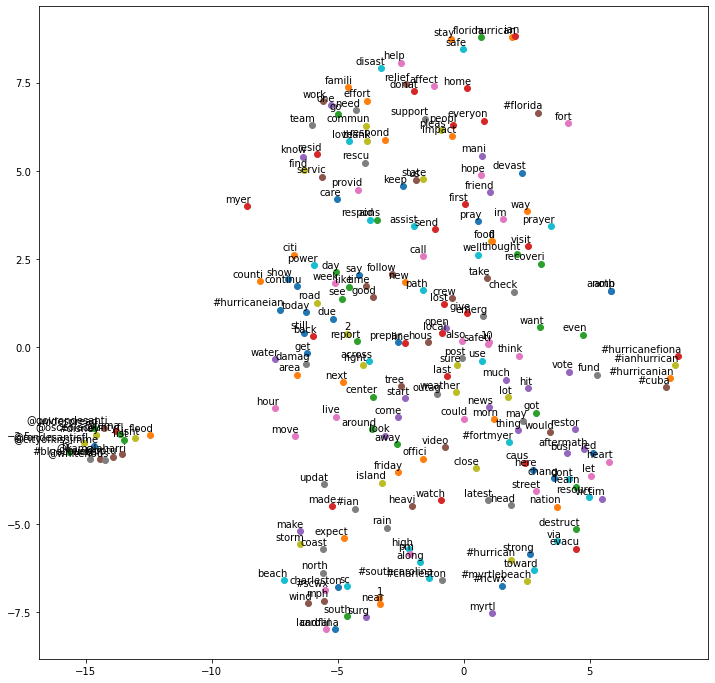

In [189]:
clean_tweets = []
for tweet in lines: 
        #get the terms cleaned 
        clean_tweets.append(build_terms(tweet['full_text']))
model = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)
tsne_plot(model)